# Data processing for big data with Apache Spark
## Thanasak Harisombut

Date: 05/09/2020

Version: 1.0

Environment: Python 3.7.4, Apache Spark, and Jupyter notebook

## 1. Working with RDD
### 1.1 Data preparation and loading
#### 1.1.1

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
master = "local[*]"

# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Project 1"

# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

#### 1.1.2

In [2]:
unit_rdd = sc.textFile('data/201[5-9]_DATA_SA_Units.csv')

#### 1.1.3

In [3]:
crash_rdd = sc.textFile('data/201[5-9]_DATA_SA_Crash.csv')

#### 1.1.4

In [4]:
unit_header = unit_rdd.first()
unit_rdd = unit_rdd.filter(lambda row: row != unit_header)   #filter out header

print('Total count of unit:', unit_rdd.count())
print('First 10 records: ')
unit_rdd.take(10)

Total count of unit: 153854
First 10 records: 


['"2016-1-15/08/2019","01",0,"SA","OMNIBUS","2011","North","Male","056","SA","HR","Full","Not Towing","Straight Ahead","010","5121",,',
 '"2016-1-15/08/2019","02",1,,"Pedestrian on Road",,"East","Male","072",,,,,"Walking on Road",,"5084",,',
 '"2016-2-15/08/2019","01",0,"SA","Motor Cars - Sedan","2004","Unknown","Female","023","SA","C ","Full","Not Towing","Straight Ahead","001","5087",,',
 '"2016-2-15/08/2019","02",0,"SA","Station Wagon","2008","Unknown","Male","040","SA","C ","Full","Not Towing","Straight Ahead","001","5084",,',
 '"2016-3-15/08/2019","01",0,"SA","RIGID TRUCK LGE GE 4.5T","1990","South","Unknown","XXX","SA","MR","Provisional 2","Not Towing","Straight Ahead","001","5115",,',
 '"2016-3-15/08/2019","02",0,"SA","Panel Van","2013","South","Male","023","SA","C ","Full","Not Towing","Straight Ahead","001","5110",,',
 '"2016-4-15/08/2019","01",0,"SA","Station Wagon","2002","East","Female","033","SA","C ","Full","Not Towing","Straight Ahead","001","5169",,',
 '"2016-4-15/08/20

In [5]:
crash_header = crash_rdd.first()
crash_rdd = crash_rdd.filter(lambda row: row != crash_header)   #filter out header

print('Total count of unit:', crash_rdd.count())
print('First 10 records: ')
crash_rdd.take(10)

Total count of unit: 72006
First 10 records: 


['"2019-1-8/07/2020","2 Metropolitan","HAMPSTEAD GARDENS","5086","CITY OF PORT ADELAIDE ENFIELD",2,0,0,0,0,2019,"June","Wednesday","11:15 am","060","Cross Road","Straight road","Level","Not Applicable","Sealed","Dry","Not Raining","Daylight","Right Angle","01","Driver Rider","1: PDO","Give Way Sign","","",1331810.03,1676603.26,"13318101676603"',
 '"2019-2-8/07/2020","2 Metropolitan","DRY CREEK","5094","CITY OF SALISBURY",2,0,0,0,0,2019,"January","Tuesday","12:49 am","090","Divided Road","Straight road","Level","Not Applicable","Sealed","Dry","Not Raining","Night","Rear End","02","Driver Rider","1: PDO","No Control","","",1328376.2,1682942.63,"13283761682943"',
 '"2019-3-8/07/2020","2 Metropolitan","MILE END","5031","CITY OF WEST TORRENS",2,1,0,0,1,2019,"January","Tuesday","12:00 am","060","Divided Road","Straight road","Level","Not Applicable","Sealed","Dry","Not Raining","Night","Hit Pedestrian","01","Driver Rider","2: MI","No Control","","",1325819.68,1670994.26,"13258201670994"',
 '

### 1.2 Data Partitioning in RDD
#### 1.2.1

#### How many partitions do the above RDDs have?

In [6]:
print("Unit RDD Partition number:", unit_rdd.getNumPartitions())
print("Crash RDD Partition number:", crash_rdd.getNumPartitions())

Unit RDD Partition number: 5
Crash RDD Partition number: 5


#### How is the data in these RDDs partitioned by default,  when we do not explicitly specify any partitioning strategy?

The Spark will consider the file size, block size, and calculate the number of the partition. Furthermore, the data will be distributed randomly equal to all partitions.

In [7]:
def print_partition(rdd):
    numPartitions = rdd.getNumPartitions()
    partitions = rdd.glom().collect()
    print(f"NUMBER OF PARTITIONS: {numPartitions}")
    for index, partition in enumerate(partitions):
        # show partition if it is not empty
        if len(partition) > 0:
            print(f"- Partition {index}: {len(partition)} records")
print('####### Unit RDD #######')
print_partition(unit_rdd)
print('\n####### Crash RDD #######')
print_partition(crash_rdd)

####### Unit RDD #######
NUMBER OF PARTITIONS: 5
- Partition 0: 35861 records
- Partition 1: 28163 records
- Partition 2: 33084 records
- Partition 3: 27713 records
- Partition 4: 29033 records

####### Crash RDD #######
NUMBER OF PARTITIONS: 5
- Partition 0: 12964 records
- Partition 1: 16775 records
- Partition 2: 13237 records
- Partition 3: 13599 records
- Partition 4: 15431 records


#### 1.2.2

In [8]:
# a) Create a key Value pair with Lic Sate
trnf_unit_rdd = unit_rdd.map(lambda x: x.split(",")) \
    .map(lambda x: [s.strip("\"") for s in x]).map(lambda x: (x[9], x[0:9] + x[10:]))

In [9]:
# b) Hash Function and implement Hash Partitioning
def hash_function(key):
    if key.lower() == 'sa':
        return 0
    else:
        return 1
no_of_partitions = 2
partitioned_unit_rdd = trnf_unit_rdd.partitionBy(no_of_partitions, hash_function)

In [10]:
# c) checking unit's partition by hash function
print('####### Hash Partitioned Unit RDD #######')
print_partition(partitioned_unit_rdd)

####### Hash Partitioned Unit RDD #######
NUMBER OF PARTITIONS: 2
- Partition 0: 109684 records
- Partition 1: 44170 records


#### Answer
For the data skewness, we can see that the first partition (SA State) has a significantly larger amount than the second partition (Other States). 

Thus, it will have a poorly performance once working on this structure.

### 1.3 Query/Analysis
#### 1.3.1

In [11]:
filtered_driver_rdd = unit_rdd.map(lambda x: x.split(",")) \
                    .map(lambda x: (x[7].strip("\""), x[8].strip("\""))) \
                    .filter(lambda x: x[1].isnumeric() and (x[0].lower()=="male" or x[0].lower()=="female")) \
                    .map(lambda x: (x[0], int(x[1])))

avg_age_rdd = filtered_driver_rdd.mapValues(lambda v: (v, 1)) \
                                .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])) \
                                .mapValues(lambda v: v[0]/v[1])

print( "The average male age: ", round(avg_age_rdd.collectAsMap()['Male'],2))
print( "The average female age: ", round(avg_age_rdd.collectAsMap()['Female'],2))

The average male age:  40.98
The average female age:  40.39


#### 1.3.2


In [12]:
veh_involved_rdd = unit_rdd.map(lambda x: x.split(",")) \
                .map(lambda x: (x[3].strip("\""),x[5].strip("\""),x[4].strip("\""))) \
                .filter(lambda x: x[1].isnumeric()) \
                .sortBy(lambda x: x[1], ascending=True)
the_oldest_v = veh_involved_rdd.first()
the_newest_v = veh_involved_rdd.collect()[veh_involved_rdd.count()-1]

veh_involved_rdd = veh_involved_rdd.filter(lambda x: x==the_oldest_v or x ==the_newest_v).distinct() \
                                    .sortBy(lambda x: x[1], ascending=True)

print("The oldest vehicle year involved in accident:", veh_involved_rdd.first())
print("The newest vehicle year involved in accident:", veh_involved_rdd.collect()[veh_involved_rdd.count()-1])

The oldest vehicle year involved in accident: ('VIC', '1900', 'Motor Cycle')
The newest vehicle year involved in accident: ('SA', '2019', 'Motor Cars - Sedan')


## 2. Working with DataFrame

### 2.1 Data Preparation and Loading

#### 2.1.1 Load all data into dataframes

In [13]:
# Read csv file and load into a dataframe
unit_file_name = ['data/20'+ str(x) +'_DATA_SA_Units.csv' for x in range(15,20)]
crash_file_name = ['data/20'+ str(x) +'_DATA_SA_Crash.csv' for x in range(15,20)]
unit_df = spark.read.csv(unit_file_name, header=True)
crash_df = spark.read.csv(crash_file_name, header=True)

#### 2.1.2 Display the schema

In [14]:
print(f"####### UNITS INFO:")
unit_df.printSchema()
print(f"####### CRASH INFO:")
crash_df.printSchema()

####### UNITS INFO:
root
 |-- REPORT_ID: string (nullable = true)
 |-- Unit No: string (nullable = true)
 |-- No Of Cas: string (nullable = true)
 |-- Veh Reg State: string (nullable = true)
 |-- Unit Type: string (nullable = true)
 |-- Veh Year: string (nullable = true)
 |-- Direction Of Travel: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Lic State: string (nullable = true)
 |-- Licence Class: string (nullable = true)
 |-- Licence Type: string (nullable = true)
 |-- Towing: string (nullable = true)
 |-- Unit Movement: string (nullable = true)
 |-- Number Occupants: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Rollover: string (nullable = true)
 |-- Fire: string (nullable = true)

####### CRASH INFO:
root
 |-- REPORT_ID: string (nullable = true)
 |-- Stats Area: string (nullable = true)
 |-- Suburb: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- LGA Name: string (nullable = true)
 |-

### 2.2 Query/Analysis

#### 2.2.1

In [15]:
from pyspark.sql.types import IntegerType
crash_df = crash_df.withColumn('Total Cas', crash_df['Total Cas'].cast(IntegerType()))
crash_ADE_df = crash_df.filter("Suburb = 'ADELAIDE'")
crash_ADE_df = crash_ADE_df.where(crash_ADE_df['Total Cas'] > 3)
crash_ADE_df.show()

+--------------------+----------+--------+--------+----------------+-----------+---------+----------+--------+--------+----+--------+--------+--------+----------+-------------+----------------+--------------+--------------------+------------+-------------+------------+--------+--------------+---------+------------+-------------+---------------+------------+--------------+----------+----------+--------------+
|           REPORT_ID|Stats Area|  Suburb|Postcode|        LGA Name|Total Units|Total Cas|Total Fats|Total SI|Total MI|Year|   Month|     Day|    Time|Area Speed|Position Type|Horizontal Align|Vertical Align|          Other Feat|Road Surface|Moisture Cond|Weather Cond|DayNight|    Crash Type|Unit Resp| Entity Code|CSEF Severity|  Traffic Ctrls|DUI Involved|Drugs Involved|  ACCLOC_X|  ACCLOC_Y|    UNIQUE_LOC|
+--------------------+----------+--------+--------+----------------+-----------+---------+----------+--------+--------+----+--------+--------+--------+----------+-------------+

#### 2.2.2

In [16]:
crash_top10_df = crash_df.orderBy('Total cas', ascending=False).limit(10)
crash_top10_df.orderBy('Total cas', ascending=False).show()

+--------------------+--------------+-------------+--------+--------------------+-----------+---------+----------+--------+--------+----+--------+---------+--------+----------+-------------+--------------------+--------------+--------------+------------+-------------+------------+--------+-----------+---------+------------+-------------+---------------+------------+--------------+----------+----------+--------------+
|           REPORT_ID|    Stats Area|       Suburb|Postcode|            LGA Name|Total Units|Total Cas|Total Fats|Total SI|Total MI|Year|   Month|      Day|    Time|Area Speed|Position Type|    Horizontal Align|Vertical Align|    Other Feat|Road Surface|Moisture Cond|Weather Cond|DayNight| Crash Type|Unit Resp| Entity Code|CSEF Severity|  Traffic Ctrls|DUI Involved|Drugs Involved|  ACCLOC_X|  ACCLOC_Y|    UNIQUE_LOC|
+--------------------+--------------+-------------+--------+--------------------+-----------+---------+----------+--------+--------+----+--------+---------+--

#### 2.2.3

In [17]:
crash_df = crash_df.withColumn('Total Fats', crash_df['Total Fats'].cast(IntegerType())) 

crash_type_cnt_df = crash_df.groupby('Crash Type').sum('Total Fats') \
                        .withColumnRenamed('sum(Total Fats)', 'Total Fats')
crash_type_cnt_df.show()

+--------------------+----------+
|          Crash Type|Total Fats|
+--------------------+----------+
|           Roll Over|        57|
|  Hit Object on Road|         2|
|      Hit Pedestrian|        70|
|    Hit Fixed Object|       152|
|               Other|         2|
|          Side Swipe|        20|
|             Head On|        86|
|  Hit Parked Vehicle|         9|
|          Right Turn|        18|
|            Rear End|        16|
|          Hit Animal|         4|
|Left Road - Out o...|         1|
|         Right Angle|        45|
+--------------------+----------+



#### 2.2.4

In [18]:
unlicensed_crash_df = unit_df.where(unit_df['Licence Type'] == 'Unlicenced').select('REPORT_ID').distinct()
unlicensed_crash_df = crash_df.join(unlicensed_crash_df, crash_df.REPORT_ID == unlicensed_crash_df.REPORT_ID, \
                        how='left_semi').groupby('Suburb').sum('Total Cas') \
                        .withColumnRenamed('sum(Total Cas)', 'Total Casualties')
unlicensed_crash_df.show()

+-------------------+----------------+
|             Suburb|Total Casualties|
+-------------------+----------------+
|      FLINDERS PARK|               8|
|       POOGINAGORIC|               1|
|     TEA TREE GULLY|               1|
|            HACKHAM|               3|
|   MEDINDIE GARDENS|               0|
|           WISANGER|               1|
|            CUMMINS|               0|
|       BASKET RANGE|               0|
|MURRAY BRIDGE SOUTH|               0|
|      GILLES PLAINS|               7|
|             HAWKER|               0|
|           BEAUFORT|               1|
|             MAGILL|               7|
|            ECHUNGA|               1|
|            CULTANA|               1|
|        EDWARDSTOWN|               5|
|        RISDON PARK|               1|
|          THORNGATE|               1|
|       ANDREWS FARM|              12|
|       TORRENSVILLE|               5|
+-------------------+----------------+
only showing top 20 rows



## 2.3 Severity Analysis

#### 2.3.1

In [19]:
severity_cnt_df = crash_df.groupBy('CSEF Severity').count()
severity_cnt_df.show()

+-------------+-----+
|CSEF Severity|count|
+-------------+-----+
|     4: Fatal|  451|
|        2: MI|21881|
|       1: PDO|46696|
|        3: SI| 2978|
+-------------+-----+



<b> Which severity level is the most common? </b>

The property damage only (PDO) is the most common accident between 2015 and 2019, which happened 46,696 times.

#### 2.3.2 a

In [20]:
total_DI_accident = crash_df.filter(crash_df['Drugs Involved'] =='Y').count()

In [21]:
severity_cnt_DI_df = crash_df.filter(crash_df['Drugs Involved'] =='Y') \
                    .groupBy('CSEF Severity').count()
severity_cnt_DI_df = severity_cnt_DI_df.withColumn('Percentage', severity_cnt_DI_df['count']/total_DI_accident * 100)
print('a. When the driver is tested positive on drugs.')
severity_cnt_DI_df.show()

a. When the driver is tested positive on drugs.
+-------------+-----+------------------+
|CSEF Severity|count|        Percentage|
+-------------+-----+------------------+
|     4: Fatal|   82| 6.539074960127592|
|        2: MI|  749|59.728867623604465|
|       1: PDO|  176|14.035087719298245|
|        3: SI|  247|19.696969696969695|
+-------------+-----+------------------+



#### 2.3.2 b

In [22]:
total_DUI_accident = crash_df.filter(crash_df['DUI Involved'] =='Y').count()

In [23]:
severity_cnt_DUI_df = crash_df.filter(crash_df['DUI Involved'] =='Y') \
                    .groupBy('CSEF Severity').count()
severity_cnt_DUI_df = severity_cnt_DUI_df.withColumn('Percentage', severity_cnt_DUI_df['count']/total_DUI_accident * 100)

print('b. When the driver is tested positive for blood alcohol concentration.')
severity_cnt_DUI_df.show()

b. When the driver is tested positive for blood alcohol concentration.
+-------------+-----+------------------+
|CSEF Severity|count|        Percentage|
+-------------+-----+------------------+
|     4: Fatal|   79|  3.51423487544484|
|        2: MI|  737|  32.7846975088968|
|       1: PDO| 1173|52.179715302491104|
|        3: SI|  259| 11.52135231316726|
+-------------+-----+------------------+



#### 2.3.2 c

In [24]:
total_DI_DUI_accident = crash_df.filter((crash_df['Drugs Involved'] =='Y') & (crash_df['DUI Involved'] =='Y')).count()

In [25]:
severity_cnt_DI_DUI_df = crash_df.filter((crash_df['Drugs Involved'] =='Y') & (crash_df['DUI Involved'] =='Y')) \
                                .groupBy('CSEF Severity').count()
severity_cnt_DI_DUI_df = severity_cnt_DI_DUI_df.withColumn('Percentage', severity_cnt_DI_DUI_df['count']/total_DI_DUI_accident * 100)

print('c. When the driver is tested positive for both drugs and blood alcohol.')
severity_cnt_DI_DUI_df.show()

c. When the driver is tested positive for both drugs and blood alcohol.
+-------------+-----+------------------+
|CSEF Severity|count|        Percentage|
+-------------+-----+------------------+
|     4: Fatal|   27|15.428571428571427|
|        2: MI|   89|50.857142857142854|
|       1: PDO|   24|13.714285714285715|
|        3: SI|   35|              20.0|
+-------------+-----+------------------+



#### 2.3.2 d

In [26]:
severity_cnt_no_DI_DUI_df = crash_df.fillna({'Drugs Involved': '', 'DUI Involved': ''})
severity_cnt_no_DI_DUI_df = severity_cnt_no_DI_DUI_df.filter((severity_cnt_no_DI_DUI_df['Drugs Involved'] !='Y') \
                                                            & (severity_cnt_no_DI_DUI_df['DUI Involved'] !='Y'))

total_no_DI_DUI_accident = severity_cnt_no_DI_DUI_df.count()

In [27]:

severity_cnt_no_DI_DUI_df = severity_cnt_no_DI_DUI_df.groupBy('CSEF Severity').count()
severity_cnt_no_DI_DUI_df = severity_cnt_no_DI_DUI_df.withColumn('Percentage', severity_cnt_no_DI_DUI_df['count']/total_no_DI_DUI_accident * 100)

print('d. When the driver is tested negative for both (no alcohol and no drugs).')
severity_cnt_no_DI_DUI_df.show()

d. When the driver is tested negative for both (no alcohol and no drugs).
+-------------+-----+------------------+
|CSEF Severity|count|        Percentage|
+-------------+-----+------------------+
|     4: Fatal|  317| 0.461567582521586|
|        2: MI|20484|29.825710916000524|
|       1: PDO|45371| 66.06240626683557|
|        3: SI| 2507|3.6503152346423215|
+-------------+-----+------------------+



#### Compare the results in these 4 scenarios and briefly explain the observation from this analysis.

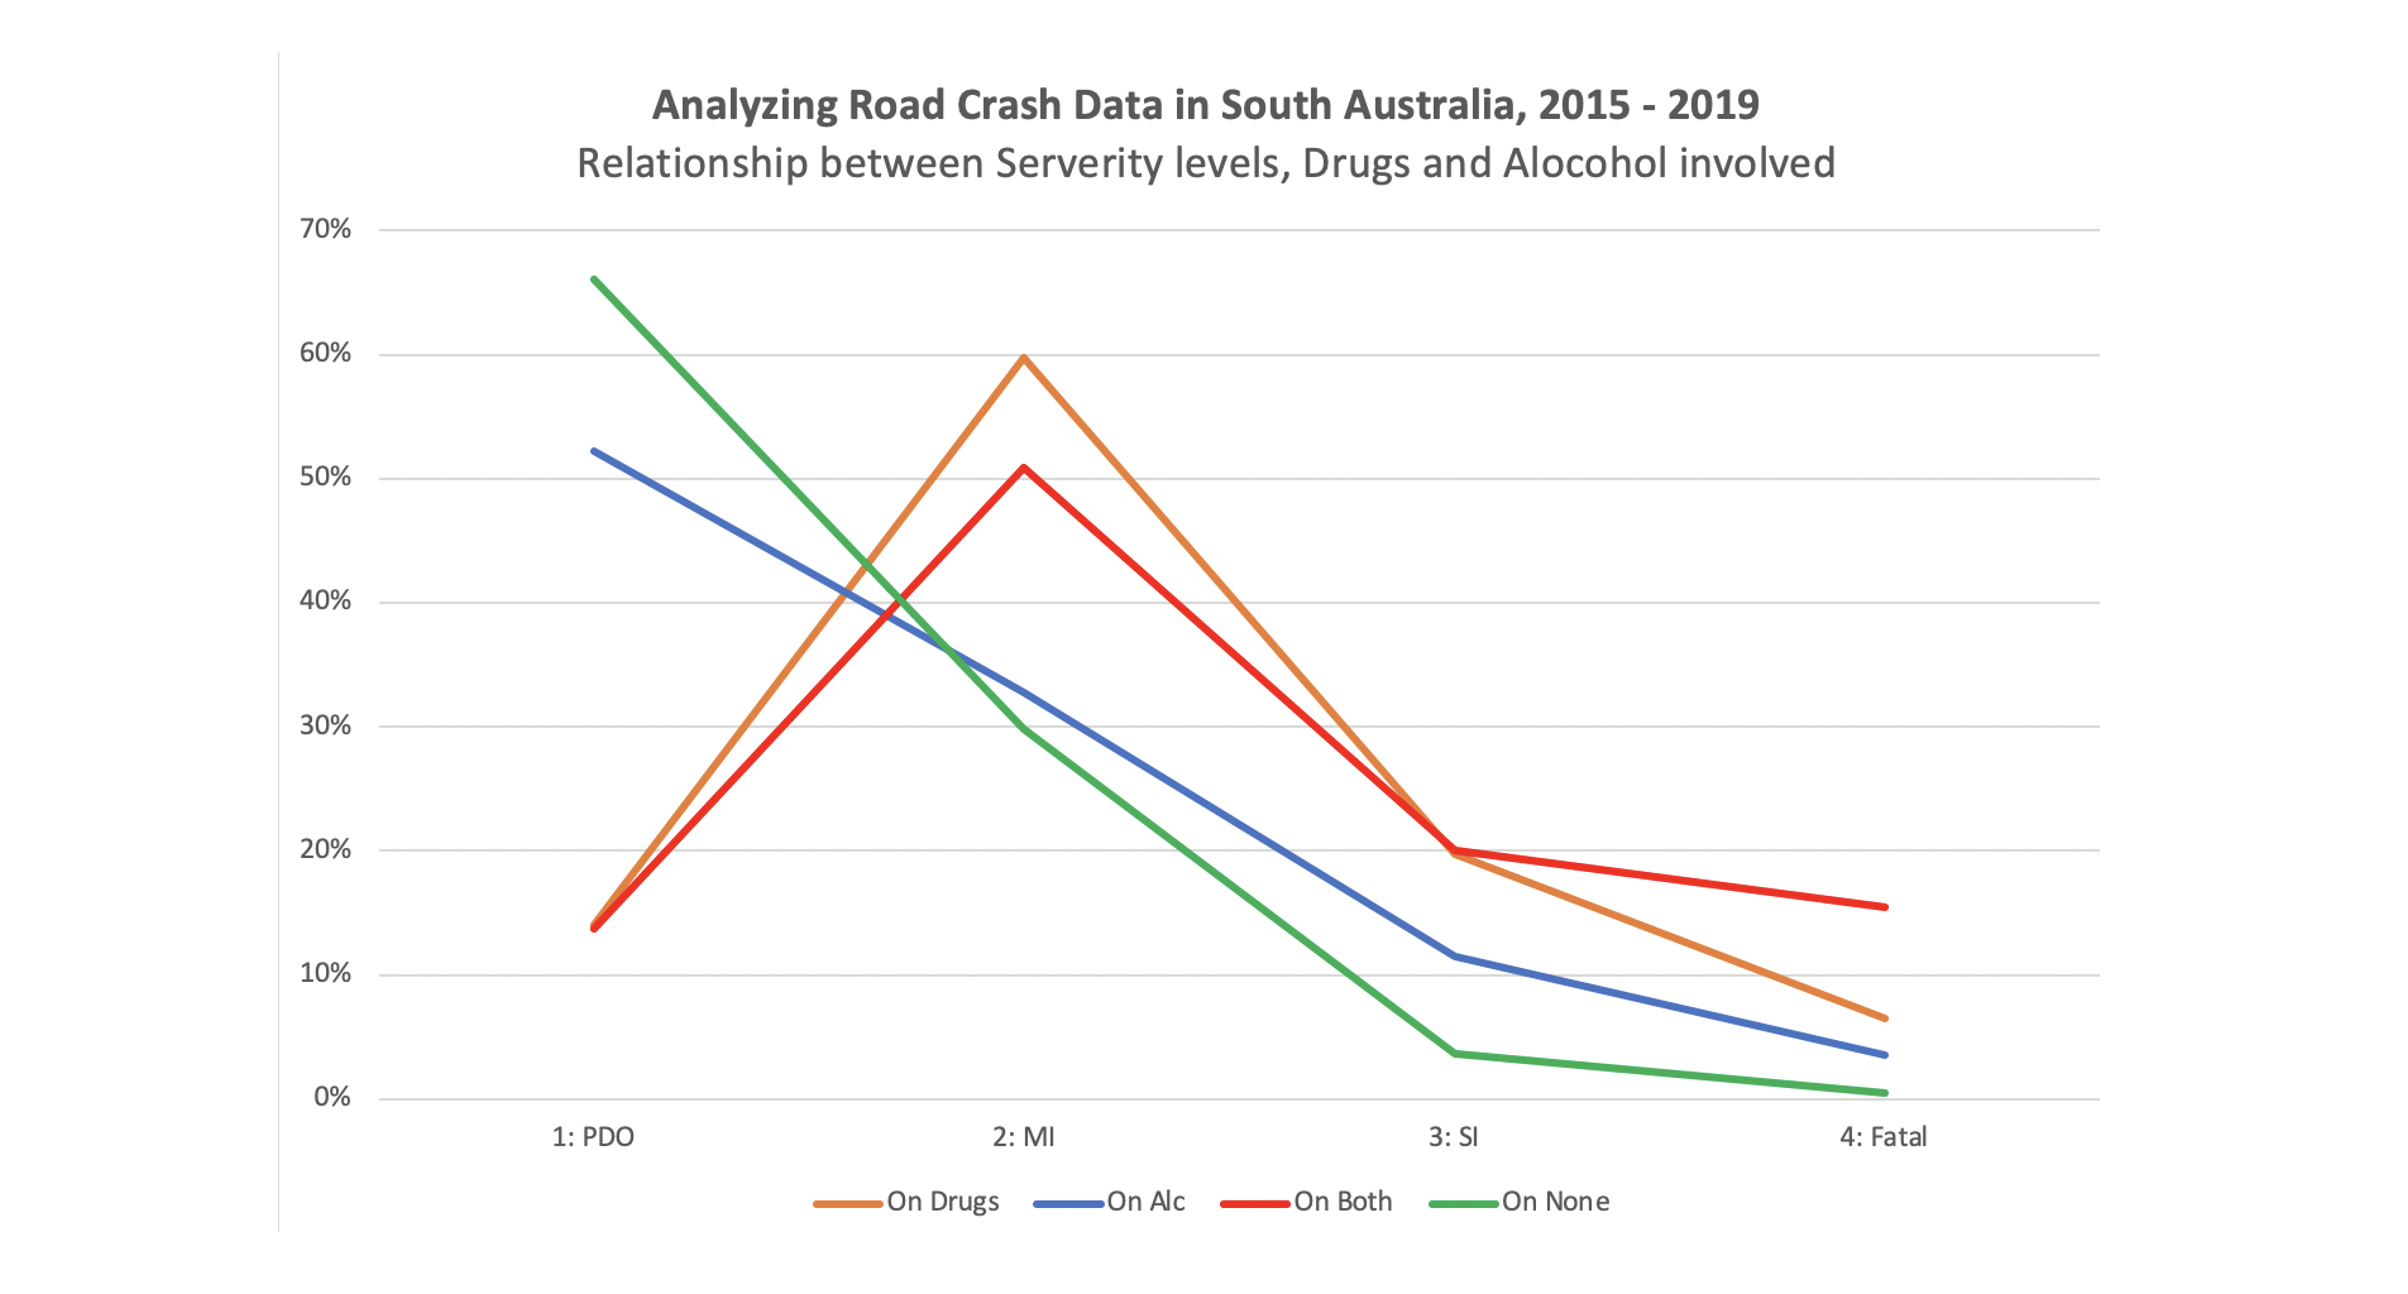

#### Answer

Comparing the severity levels of crashes, it is obvious that On Drugs and On both are significantly high chance of getting badly damaged. Furthermore, On alcohol has slightly increased a severity level and lastly, On None of them is the most potentially safest in the accident.


### 2.4 Comparasion RDDs vs DataFrame vs Spark SQL

#### 2.4.1

#### Using RDD

In [28]:
%%time
trnf_unit_rdd = unit_rdd.map(lambda x: x.split(",")) \
                    .map(lambda x: [s.strip("\"") for s in x]) \
                    .map(lambda x: (x[0], [x[7], x[8] , x[11]] ))

trnf_crash_rdd = crash_rdd.map(lambda x: x.split(",")) \
                    .map(lambda x: [s.strip("\"") for s in x]) \
                    .filter(lambda x: x[2].lower()=="adelaide") \
                    .map(lambda x: (x[0], [x[2] , x[6], x[10]+"-"+x[11]+"-"+x[12] , x[13]]))                 

result_rdd = trnf_unit_rdd.join(trnf_crash_rdd)
result_rdd = result_rdd.map(lambda x: (x[1][1][2], x[1][1][3], x[1][1][1], x[1][1][0], \
                              x[1][0][0], x[1][0][1], x[1][0][2]))

print('Total records:', result_rdd.count(), "\n")
result_rdd.take(20)

Total records: 6310 

CPU times: user 26.1 ms, sys: 5.61 ms, total: 31.7 ms
Wall time: 2.09 s


[('2016-November-Wednesday',
  '04:26 pm',
  '0',
  'ADELAIDE',
  'Male',
  '017',
  'Unknown'),
 ('2016-November-Wednesday',
  '04:26 pm',
  '0',
  'ADELAIDE',
  'Male',
  '025',
  'Unknown'),
 ('2016-December-Friday', '11:30 am', '0', 'ADELAIDE', 'Male', '080', 'Full'),
 ('2016-December-Friday', '11:30 am', '0', 'ADELAIDE', 'Male', '048', 'Full'),
 ('2016-December-Saturday',
  '07:40 am',
  '0',
  'ADELAIDE',
  'Male',
  '032',
  'Full'),
 ('2016-December-Saturday',
  '07:40 am',
  '0',
  'ADELAIDE',
  'Unknown',
  'XXX',
  'Unknown'),
 ('2016-December-Friday',
  '05:30 pm',
  '0',
  'ADELAIDE',
  'Female',
  '058',
  'Full'),
 ('2016-December-Friday', '05:30 pm', '0', 'ADELAIDE', 'Male', '041', 'Full'),
 ('2016-December-Wednesday',
  '04:20 pm',
  '0',
  'ADELAIDE',
  'Female',
  '045',
  'Full'),
 ('2016-December-Wednesday',
  '04:20 pm',
  '0',
  'ADELAIDE',
  'Male',
  '027',
  'Full'),
 ('2016-December-Wednesday',
  '04:20 pm',
  '0',
  'ADELAIDE',
  'Male',
  '041',
  'Full'),


#### Using Dataframe

In [29]:
%%time
from pyspark.sql.functions import concat, lit, col

unit_filtered_df = unit_df.select(['REPORT_ID', 'Sex', 'Age', 'Licence Type'])
crash_filtered_df = crash_df.filter(crash_df.Suburb == 'ADELAIDE') \
                            .select(['REPORT_ID','Year','Month','Day','Time','Total Cas','Suburb'])

result_df = crash_filtered_df.join(unit_filtered_df, crash_filtered_df.REPORT_ID == unit_filtered_df.REPORT_ID, how='inner')

print('Total records:', result_df.count(), "\n")
result_df.select([concat(result_df['Year'],lit('-'),result_df['Month'],lit('-'),result_df['Day']).alias("Date") \
                  ,'Time',result_df['Total Cas'].alias('Number of Casualties') \
                  ,'Suburb',result_df['Sex'].alias('Gender'), 'Age', 'Licence Type']).show(20)

Total records: 6310 

+--------------------+--------+--------------------+--------+-------+----+------------+
|                Date|    Time|Number of Casualties|  Suburb| Gender| Age|Licence Type|
+--------------------+--------+--------------------+--------+-------+----+------------+
|2016-November-Wed...|01:45 pm|                   1|ADELAIDE|   Male| 056|        Full|
|2016-November-Wed...|01:45 pm|                   1|ADELAIDE|   Male| 072|        null|
|2016-November-Tue...|03:40 pm|                   1|ADELAIDE|   Male| 056|        null|
|2016-November-Tue...|03:40 pm|                   1|ADELAIDE| Female| 027|        null|
|2016-November-Tue...|05:00 pm|                   0|ADELAIDE| Female| 032|        Full|
|2016-November-Tue...|05:00 pm|                   0|ADELAIDE|Unknown| XXX|     Unknown|
|2016-November-Tue...|05:40 pm|                   0|ADELAIDE|   Male| 022|     Unknown|
|2016-November-Tue...|05:40 pm|                   0|ADELAIDE|   Male| 020|     Unknown|
|2016-Nove

#### Using SparkSQL

In [30]:
# Create Views from Dataframes
unit_df.createOrReplaceTempView("sql_unit")
crash_df.createOrReplaceTempView("sql_crash")

In [31]:
%%time

## select data using SQL
sql_result = spark.sql('''
  SELECT CONCAT(c.Year,'-',c.Month,'-',c.Day) `Date`, c.Time , `Total cas` `Number of Casualties`,c.Suburb, u.Sex Gender, u.Age, `Licence Type`
  FROM sql_unit u JOIN sql_crash c
  ON u.REPORT_ID = c.REPORT_ID
  WHERE c.Suburb = 'ADELAIDE'
''')

print('Total records:', sql_result.count(), "\n")
sql_result.show(20)

Total records: 6310 

+--------------------+--------+--------------------+--------+-------+----+------------+
|                Date|    Time|Number of Casualties|  Suburb| Gender| Age|Licence Type|
+--------------------+--------+--------------------+--------+-------+----+------------+
|2016-November-Wed...|01:45 pm|                   1|ADELAIDE|   Male| 056|        Full|
|2016-November-Wed...|01:45 pm|                   1|ADELAIDE|   Male| 072|        null|
|2016-November-Tue...|03:40 pm|                   1|ADELAIDE|   Male| 056|        null|
|2016-November-Tue...|03:40 pm|                   1|ADELAIDE| Female| 027|        null|
|2016-November-Tue...|05:00 pm|                   0|ADELAIDE| Female| 032|        Full|
|2016-November-Tue...|05:00 pm|                   0|ADELAIDE|Unknown| XXX|     Unknown|
|2016-November-Tue...|05:40 pm|                   0|ADELAIDE|   Male| 022|     Unknown|
|2016-November-Tue...|05:40 pm|                   0|ADELAIDE|   Male| 020|     Unknown|
|2016-Nove

### 2.4.2

#### Using RDD

In [32]:
%%time
trnf_unit_rdd = unit_rdd.map(lambda x: x.split(",")) \
                    .map(lambda x: (x[0], x[11] )) \
                    .map(lambda x: [s.strip("\"") for s in x]) \
                    .filter(lambda x: x[1].lower()=="unlicenced")

trnf_crash_rdd = crash_rdd.map(lambda x: x.split(",")) \
                    .map(lambda x: [s.strip("\"") for s in x]) \
                    .map(lambda x: (x[0], [x[2], int(x[6])]))  

result_rdd = trnf_crash_rdd.join(trnf_unit_rdd).map(lambda x: (x[1][0][0],x[1][0][1]))
result_rdd = result_rdd.reduceByKey(lambda a,b: a+b) 

print('Total records:', result_rdd.count(), "\n")
result_rdd.take(20)

Total records: 634 

CPU times: user 28.4 ms, sys: 0 ns, total: 28.4 ms
Wall time: 1.74 s


[('ONKAPARINGA HILLS', 7),
 ('FIRLE', 6),
 ('RIVERGLADES', 1),
 ('SALISBURY PARK', 0),
 ('HAPPY VALLEY', 5),
 ('MUNNO PARA WEST', 1),
 ('HEATHPOOL', 3),
 ('NORTH PLYMPTON', 1),
 ('WHITES FLAT', 0),
 ('CRAIGMORE', 2),
 ('URRBRAE', 2),
 ('BIRKENHEAD', 2),
 ('PARALOWIE', 4),
 ('BERRI', 3),
 ('CLOVELLY PARK', 1),
 ('DAVOREN PARK', 8),
 ('HACKHAM', 3),
 ('MODBURY NORTH', 3),
 ('FULLARTON', 0),
 ('ASCOT PARK', 2)]

#### Using DataFrame

In [33]:
%%time

unit_filtered_df = unit_df.where(unit_df['Licence Type'] == 'Unlicenced').select('REPORT_ID')
result_df = crash_df.join(unit_filtered_df, crash_df.REPORT_ID == unit_filtered_df.REPORT_ID, \
                        how='left_semi').groupby('Suburb').sum('Total Cas') \
                        .withColumnRenamed('sum(Total Cas)', 'Total Casualties')

print('Total records:', result_df.count(), "\n")
result_df.show()

Total records: 634 

+-------------------+----------------+
|             Suburb|Total Casualties|
+-------------------+----------------+
|      FLINDERS PARK|               8|
|       POOGINAGORIC|               1|
|     TEA TREE GULLY|               1|
|            HACKHAM|               3|
|   MEDINDIE GARDENS|               0|
|           WISANGER|               1|
|            CUMMINS|               0|
|       BASKET RANGE|               0|
|MURRAY BRIDGE SOUTH|               0|
|      GILLES PLAINS|               7|
|             HAWKER|               0|
|           BEAUFORT|               1|
|             MAGILL|               7|
|            ECHUNGA|               1|
|            CULTANA|               1|
|        EDWARDSTOWN|               5|
|        RISDON PARK|               1|
|          THORNGATE|               1|
|       ANDREWS FARM|              12|
|       TORRENSVILLE|               5|
+-------------------+----------------+
only showing top 20 rows

CPU times: user 4

#### Using Spark SQL

In [34]:
%%time
## select data using SQL
sql_result = spark.sql('''
    SELECT c.suburb, sum(c.`Total cas`)
    FROM sql_crash c 
          inner join sql_unit u ON u.REPORT_ID = c.REPORT_ID
    WHERE u.`Licence Type` = 'Unlicenced'
    GROUP BY c.suburb
''')

print('Total records:', sql_result.count(), "\n")
sql_result.show(20)

Total records: 634 

+-------------------+--------------+
|             suburb|sum(Total cas)|
+-------------------+--------------+
|      FLINDERS PARK|             8|
|       POOGINAGORIC|             1|
|     TEA TREE GULLY|             1|
|            HACKHAM|             3|
|   MEDINDIE GARDENS|             0|
|           WISANGER|             1|
|            CUMMINS|             0|
|       BASKET RANGE|             0|
|MURRAY BRIDGE SOUTH|             0|
|      GILLES PLAINS|             7|
|             HAWKER|             0|
|           BEAUFORT|             1|
|             MAGILL|             7|
|            ECHUNGA|             1|
|            CULTANA|             1|
|        EDWARDSTOWN|             6|
|        RISDON PARK|             1|
|          THORNGATE|             1|
|       ANDREWS FARM|            12|
|       TORRENSVILLE|             5|
+-------------------+--------------+
only showing top 20 rows

CPU times: user 3.69 ms, sys: 0 ns, total: 3.69 ms
Wall time: 2.0